# Business Analytics

# Data Description

The use case in this fictional example is a B2B vendor with two data sources:
<br> A customer accounts data source that has a row for each customer of the vendor, and columns for:
*	the unique ID assigned to each customer,
*	the region in which the customer operates, and
*	whether a vendor partner was involved in bringing the customer in

<br> A contracts data source that has a row for each deal closed by the vendor, and columns for:

*	the date on which each deal was closed,
*	the size of each deal (in thousands ARR),
*	the length of each deal (in years),
*	the unique ID assigned to each deal, and
*	the date on which payment was received


# Importing

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime , timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# pandas .loc warning ignore
import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [ ]:
# if you want to run the code change the path to where data is
# define path for data
path=''
# reading data from specified path
accounts = pd.read_csv(path+'accounts.csv')
contracts = pd.read_csv(path+'contracts.csv')
display(contracts.head(3))
display(accounts.head(3))

,closingDate,contractSize,contractLength,contractID,paymentDate
0,2013/01/01,70.0,2,DKU-87jss3-0001,2013/04/13
1,2013/01/02,55.0,2,DKU-cwcx12-0001,2013/04/15
2,2013/01/02,95.0,1,DKU-xk6z56-0001,2013/05/11


,accountID,region,partnerInvolved
0,j58sge,North America,No
1,jbsvvx,Africa,Yes
2,529e88,EMEA,Yes


# Question 1
If payment has not been received within 45 days of the close of a deal, the vendor sends a reminder to the customer.  By region, what is the current (where "today" is December 11, 2018) overall value of contracts to be collected that are more than 45 days past close?  More than 90 days?  More than 135 days?  How does this compare to contracts closed in 2017?

## Preprocessing

1. In order to get the overall value of contracts to be collected that are more than $n$ number of days past close as of $Day_i$ at $Region_i$, we first need to merge the the accounts data and contracts data based on $id = accountID$. 
2. In order to do the above mentioned step, we need split the `contractID` column so we can have the `accountID` from contracts data.

3. In order to work with dates, we need to convert the date columns,i.e. `closingDate` and `paymentDate` into datetime format
4. We need to add `overalSize` column to the date from multiplying `contractLength` and `contractSize`: <br> $Overal Contract Value = {Contract Length}\times {Contract Size}$




In [ ]:
# handling contractID 
# splitting the contractsID column 
new_contractID_columns = contracts['contractID'].str.split("-", n = 2, expand = True)
# adding the accountID, i.e. the middle string from the above split to the contracts data
contracts ['accountID'] = new_contractID_columns[1]

In [ ]:
# converting `closingDate` and `paymentDate` column format to datetime format
contracts['closingDate'] = pd.to_datetime(contracts['closingDate'])
contracts['paymentDate'] = pd.to_datetime(contracts['paymentDate'])

In [ ]:
# merging contracts data into the accounts data using `accountID` as a key
contracts_accounts = pd.merge(accounts, contracts ,on='accountID', how='left')
# adding overal size column
contracts_accounts['overalSize'] = contracts_accounts['contractLength']*contracts_accounts['contractSize']

## Analysis

In order to find the regional overal value to be collected as of a certain day we create a function using the following logic: 

* For 2018, the deals that are $n$ days and more past close from today, i.e. 12/11/2018, are the deals that we have not recieved any payment $n$ days ago and before, which is actually when the `payment_Date` is `null` for those date

* for contracts closed in 2017, we look at the last day in 2017 that a deal has been closed, which according to the data is 12/30/2017. So the deals that have been more than $n$ days and before past close from 12/30/2017, are the deals that `payment_Date` is after 12/30/2017. 
* we might also want to know that how many contracts are $n$ number of days past close exist per region and year

In [ ]:
# this function returns the overal contract value to be collected that are more than n number of days past close from a Day_i 
def regional_overal_value_not_paid(data,year,n,day):
  """
  n is the number of day that the contract is past close
  day is the reference date in datetime format
  year is the year that we are looking at
  """
  # finding the closing date of the deal that has been n days past close from a certain day
  closing_date = day-timedelta(days = n)
  # finding the deals that have to be collected 
  if year == 2018:
    to_be_collected = data [(data.closingDate < closing_date ) &  (data.paymentDate.isnull())]
  if year == 2017:
    to_be_collected = data [(data.closingDate < closing_date ) &  (data.paymentDate > day)]
  # grouping the data on region and sum over `overalSize`
  regional_overal_value = to_be_collected.groupby(['region']).sum()['overalSize'].reset_index()
  # we might also w
  regional_contract_numbers = to_be_collected.groupby(['region']).size().reset_index()
  return regional_overal_value,regional_contract_numbers


Overal contract values to be collected which are 45 days or more past close:


region,overalSize_2018,overalSize_2017
APAC,$7319K,$9556K
Africa,$1880K,$4202K
EMEA,$22142K,$21609K
Latin America,$1225K,$2218K
North America,$16213K,$20389K


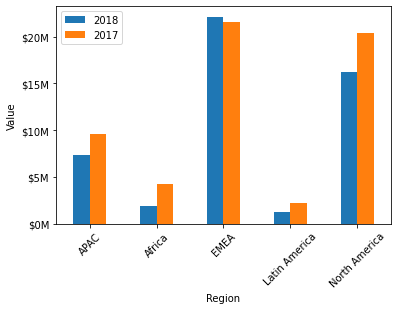

The number of total contracts that are 45 days or more past close:


region,0_2018,0_2017
APAC,25,36
Africa,7,17
EMEA,50,65
Latin America,6,8
North America,40,61


Overal contract values to be collected which are 90 days or more past close:


region,overalSize_2018,overalSize_2017
APAC,$991K,$1720K
Africa,$197K,$174K
EMEA,$3786K,$5608K
Latin America,$172K,$nanK
North America,$3647K,$2471K


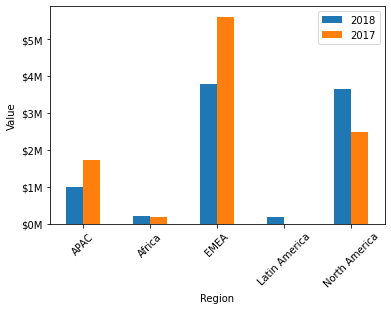

The number of total contracts that are 90 days or more past close:


region,0_2018,0_2017
APAC,4,9
Africa,2,1
EMEA,7,11
Latin America,2,nan
North America,8,9


Overal contract values to be collected which are 135 days or more past close:
No contract has been 135 days or more past close as of today,i.e., 12-11-2018
No contract has been 135 days or more past close as of 2017-12-30


In [ ]:
# make a list of the n number of days that a deal past close
due_days = [ 45, 90, 135]

# assuming today's date is 12/11/2018
day_2018 = datetime(2018,12,11)
# the last day of 2017 according to the data
day_2017 = datetime(2017,12,30)
# looping over due_days list to find the numbers per region
for n in due_days :
  # regional overal value to be collected for 2017,2018
  regional_overal_value_2018,regional_contract_numbers_2018 = regional_overal_value_not_paid(contracts_accounts,2018,n,day_2018)
  regional_overal_value_2017,regional_contract_numbers_2017= regional_overal_value_not_paid(contracts_accounts,2017,n,day_2017)
  # merging overal value to be collected of 2017 and 2018
  regional_overal_value = pd.merge(regional_overal_value_2018,regional_overal_value_2017,how='outer',on='region',suffixes=('_2018','_2017'))
  regional_contract_numbers = pd.merge(regional_contract_numbers_2018,regional_contract_numbers_2017,how='outer',on='region',suffixes=('_2018','_2017'))

  # displaying the results 
  print('\033[1m'+'Overal contract values to be collected which are '+str(n)+' days or more past close:')
  # show a message if there is no value to be collected 
  if not len(regional_overal_value_2018):
    print('No contract has been '+str(n)+' days or more past close as of today,i.e., 12-11-2018')
  if not len(regional_overal_value_2017):
    print('No contract has been '+str(n)+' days or more past close as of '+day_2017.strftime('%Y-%m-%d'))
  # bar chart of overal value to be collected for 2017 and 2018
  if len(regional_overal_value_2018) or len(regional_overal_value_2017) :
    format_dict = {col_name: '${:1.0f}K' for col_name in regional_overal_value.select_dtypes(float).columns}
    display(regional_overal_value.style.format(format_dict).hide_index())
    ax = regional_overal_value.plot(x="region", y=['overalSize_2018','overalSize_2017'],
                               kind="bar", rot = 45)
    ax.set_ylabel('Value')
    fmt = lambda x, pos: '${:1.0f}M'.format(x*1e-3, pos)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
    ax.set_xlabel('Region')
    ax.legend(['2018','2017'])
    plt.show()
    print('\033[1m'+'The number of total contracts that are '+str(n)+' days or more past close:')
    format_dict = {col_name: '{:1.0f}' for col_name in regional_contract_numbers.select_dtypes(float).columns}
    display(regional_contract_numbers.style.format(format_dict).hide_index())



# Question 2
Identify the customers who have churned.  Is there a relationship between churn and whether a partner was involved in bringing the customer to the vendor, or the region in which the customer operates, or the size or length of the contracts the customer has signed with the vendor?

## Preprocessing

1. In order to find whether a customer has churned or not, we first need to find when the last deal happened for each customer.
2. Since, we only want to analyze the churning customer behavior, we only keep the information of the last deal.
3. In order to find out which customer has churned, we need to find the end date of the last contract
<br> $Contract End Date = Contract Length\times 365 + Contract Closing Date$


In [ ]:
# adding the latest closingDate of each customer to the data
contracts_accounts['LatestclosingDate'] = contracts_accounts['closingDate'].groupby(contracts_accounts['accountID']).transform('max')
# keeping only the information of the last deal for each customer
contracts_accounts_unique = contracts_accounts.loc[contracts_accounts['closingDate']==contracts_accounts['LatestclosingDate'],:]
# adding ending contract date
contracts_accounts_unique ['endingcontractDate'] = contracts_accounts_unique['contractLength'].apply(lambda x: timedelta(days = x*365))+contracts_accounts_unique['LatestclosingDate']


## Analysis

In order to analyze the behavior of churning customers, we need to first lable them, meaning that if the `endingcontractDate` of a customer is before today's date. i.e., `12/11/2018`, they have churned, else , they have not churned.  

Then we can compare the churning customers rate for different regions, partner involvement, contract size and contract length, to see if there is any special behavior for churning customers. We can do this by finding the rate of churning customers for diffferent `region`, `partnerInvolved` and `contractLength`. 

$Churn Rate = \frac{Lost Customers}{Total Customers}$

Please note that, in order to group `contractSize`, we should first bin the `contractSize` column. 

<br>[0,100K)
<br> [100k,200k)
<br> [200k,300k)
<br> [300k,400k)
<br> [400k,500k)
<br> [500k,600k)

In [ ]:
# adding churned/not_churned labels
contracts_accounts_unique.loc[contracts_accounts_unique['endingcontractDate'] < datetime(2018,12,11),'churnedStatus'] = 'churned'
contracts_accounts_unique.loc[contracts_accounts_unique['endingcontractDate'] >= datetime(2018,12,11),'churnedStatus'] = 'not_churned'
# bin the contractSize
cut_labels = ['[0,100K)','[100k,200k)','[200k,300k)','[300k,400k)','[400k,500k)','[500k,600k)']
cut_bins = [0, 100, 200, 300, 400 , 500, 600]
contracts_accounts_unique['contractSizeBin'] = pd.cut(contracts_accounts_unique['contractSize'], bins=cut_bins, labels=cut_labels)

In [ ]:
# a function to find the churn rate for each attribute
def finding_churning_rate(data,attribute_name):
  """
  data : labeled accounts data
  attribute_name: the attribute we want to compare the churn rate with
  """
  # seperating churned and not_churned data, in order to find churn rate
  churned = data[data['churnedStatus']=='churned']
  notchurned = data[data['churnedStatus']=='not_churned']
  # group by churnedStatus and attribute
  churned_attribute = churned.groupby(['churnedStatus',attribute_name]).size().reset_index()
  notchurned_attribute = notchurned.groupby(['churnedStatus',attribute_name]).size().reset_index()
  # merging above data 
  churning_attribute = pd.merge(churned_attribute,notchurned_attribute,how='outer',on=attribute_name,suffixes=('_churned','_notchurned'))
  # delete the status column
  del churning_attribute['churnedStatus_churned']
  del churning_attribute['churnedStatus_notchurned']
  # finding the churn rate
  churning_attribute ['churningRate'] = churning_attribute ['0_churned']*100/(churning_attribute ['0_churned']+churning_attribute ['0_notchurned'])
  return churning_attribute

In [ ]:
# finding the churn rate for different partner involvement
churning_partnerinvolved = finding_churning_rate(contracts_accounts_unique,'partnerInvolved')
# finding the churn rate for different regions
churning_region = finding_churning_rate(contracts_accounts_unique,'region')
# finding the churn rate for different contract length
churning_contractlength = finding_churning_rate(contracts_accounts_unique,'contractLength')
# finding the churn rate for different contract size bins
churning_contractsize = finding_churning_rate(contracts_accounts_unique,'contractSizeBin')


In [ ]:
# display the data
print('\033[1m'+'Customer churn rate for different regions')
format_dict = {'churningRate': '{:.1f}%'}
display(churning_region[['region','churningRate']].style.format(format_dict).hide_index())

Customer churn rate for different regions


region,churningRate
APAC,20.8%
Africa,22.1%
EMEA,17.1%
Latin America,29.2%
North America,18.9%


It seems the churn rate in Latine America is bigger than other region. But the question is how big it is and why?

In [ ]:
print('\033[1m'+'Customer churn rate for partner involvement')
# display the data
format_dict = {'churningRate': '{:.1f}%'}
display(churning_partnerinvolved[['partnerInvolved','churningRate']].style.format(format_dict).hide_index())

Customer churn rate for partner involvement


partnerInvolved,churningRate
No,17.7%
Yes,25.0%


In [ ]:
print('\033[1m'+'Customer churn rate for different contract length')
# display the data
format_dict = {'churningRate': '{:.1f}%'}
display(churning_contractlength[['contractLength','churningRate']].style.format(format_dict).hide_index())

Customer churn rate for different contract length


contractLength,churningRate
1,40.3%
2,20.0%
3,9.7%


In [ ]:
print('\033[1m'+'Customer churn rate for different contract size')
# display the data
format_dict = {'churningRate': '{:.1f}%'}
display(churning_contractsize[['contractSizeBin','churningRate']].style.format(format_dict).hide_index())

Customer churn rate for different contract size


contractSizeBin,churningRate
"[0,100K)",25.8%
"[100k,200k)",18.0%
"[200k,300k)",15.2%
"[300k,400k)",10.2%
"[400k,500k)",10.3%
"[500k,600k)",0.0%


The more the length of contract and the size of a contract is, the less likely the customer churns. 

Since the Latin America has the larger churn rate, we would like to see if it is related to the contract size or contract length. 



In [ ]:
accounts_latinamerica = contracts_accounts_unique[contracts_accounts_unique.region=='Latin America']
# finding the churn rate of Latin America for different contract length
churning_contractlength_latinamerica = finding_churning_rate(accounts_latinamerica,'contractLength')
# finding the churn rate of Latin America for different contract size bins
churning_contractsize_latinamerica = finding_churning_rate(accounts_latinamerica,'contractSizeBin')

In [ ]:
print('\033[1m'+'Customer churn rate of latin America for different contract size and length')

# display the data
format_dict = {'churningRate': '{:.1f}%'}
display(churning_contractlength_latinamerica[['contractLength','churningRate']].style.format(format_dict).hide_index())
# display the data
format_dict = {'churningRate': '{:.1f}%'}
display(churning_contractsize_latinamerica[['contractSizeBin','churningRate']].style.format(format_dict).hide_index())

Customer churn rate of latin America for different contract size and length


contractLength,churningRate
1,46.3%
2,28.6%
3,22.0%


contractSizeBin,churningRate
"[0,100K)",28.9%
"[100k,200k)",32.1%
"[200k,300k)",16.7%
"[300k,400k)",42.9%
"[400k,500k)",0.0%
"[500k,600k)",nan%


# Future Steps



1.   Question 1:


*   Add different number of past close days data to the bar plot, so we can compare the overal contract value of different years and different number of past close days at the same time.
*   T-test for 2017, 2018 overal contract value to see if there is a significant difference between different years


2.   Question 2:
* What is a relation of churning customer with how many times they renewed.
* After how many years of renewal, a customer usually churns?
* Compare the Churn Rate for different years based on the ending contract date.
* How many customers have not renewd right after the previous contract ended.
* Find T-test values of churned data and not churned data for different attributes to udnerstand how significant the difference is.



**Other Insights**: correlation between size and length for churned and not_churned

In [ ]:
print(len(accounts),accounts.accountID.nunique())
print(len(contracts),contracts.accountID.nunique(),contracts.contractID.nunique())


3000 3000
6092 3000 6092


Compring number of unique accountID and contractID show that on average each customer renewed their contract 2 times.

In [ ]:
# correlation plot
sns.set(style="white")
# features to be selected for correlation plot
selected_features = ['contractSize','contractLength']
# Compute the correlation matrix for non churning customers
corr = contracts_accounts_unique[contracts_accounts_unique.churnedStatus=='not_churned'][selected_features] .corr()
print('for non churning customers:\n',corr)
# Compute the correlation matrix for churning customers
corr = contracts_accounts_unique[contracts_accounts_unique.churnedStatus=='churned'][selected_features] .corr()
print('for churning customers:\n',corr)

for non churning customers:
                 contractSize  contractLength
contractSize        1.000000       -0.064402
contractLength     -0.064402        1.000000
for churning customers:
                 contractSize  contractLength
contractSize        1.000000        0.009878
contractLength      0.009878        1.000000


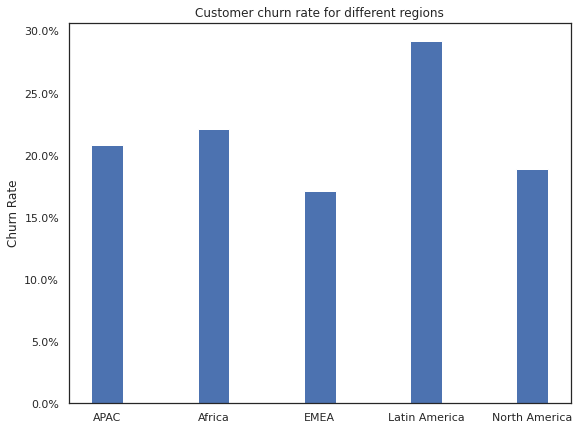

In [ ]:
# initializing the plot size
fig, ax = plt.subplots(figsize=(9,7))
# width of a bar
width = 0.3
# plotting
ax.bar(churning_region['region'], churning_region['churningRate'] , width)
ax.set_ylabel('Churn Rate')
ax.set_title('Customer churn rate for different regions')
fmt = lambda x, pos: '{:.1f}%'.format(x, pos)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.show()

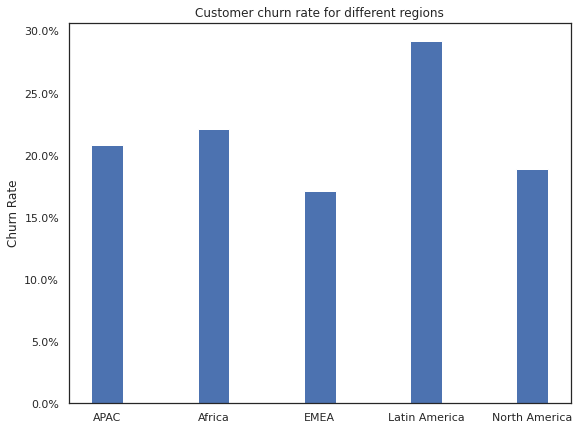

In [ ]:
# initializing the plot size
fig, ax = plt.subplots(figsize=(9,7))
# width of a bar
width = 0.3
# plotting
ax.bar(churning_region['region'], churning_region['churningRate'] , width)
ax.set_ylabel('Churn Rate')
ax.set_title('Customer churn rate for different regions')
fmt = lambda x, pos: '{:.1f}%'.format(x, pos)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
plt.show()